# Linear response


We will calculate the optical absorption in the RPA and compare it to TD simulations with a weak external field.

## RPA

First, we set up the RPA simulation. We will consider a small triangle such that the required simulation time stays in the seconds range.

In [1]:
import jax.numpy as jnp
from granad import MaterialCatalog, Triangle

# get material
graphene = MaterialCatalog.get( "graphene" )

# cut a 15 Angström wide triangle from the lattice (can also be an arbitrary polygon)
flake = graphene.cut_flake( Triangle(15)  ) 

# frequencies
omegas_rpa = jnp.linspace( 0, 5, 40 )

We obtain the polarizability for an external $x$ polarized field and from its imaginary part the absorption.

In [2]:
polarizability = flake.get_polarizability_rpa(
    omegas_rpa,
    relaxation_rate = 1/10,
    polarization = 0, 
    hungry = 2 )
absorption_rpa = jnp.abs( polarizability.imag * 4 * jnp.pi * omegas_rpa )

## TD

For the TD simulations, we specify a spectrally broad external illumination (i.e. a narrow pulse in time domain) to capture the system's response over a large frequency range.

In [3]:
from granad import Pulse
pulse = Pulse(
    amplitudes=[1e-5, 0, 0], frequency=2.3, peak=5, fwhm=2
)

We then compute the TD dipole moment and Fourier transform it.

In [4]:
omegas, dipole_omega, pulse_omega =  flake.get_expectation_value_frequency_domain(
        operator=flake.dipole_operator,  # the dipole moment is the expectation value of the dipole operator
        end_time=40,
        steps_time=1e5,
        relaxation_rate=1/10,
        illumination=pulse,
        omega_min=0,
        omega_max=5,
        skip=100,    
)

The polarizability is given by $p / E$ (we only take the $x$ - component).

In [5]:
absorption_td = jnp.abs( -omegas * jnp.imag( dipole_omega[:,0] / pulse_omega[:,0] ) )

We can now compare the two results.

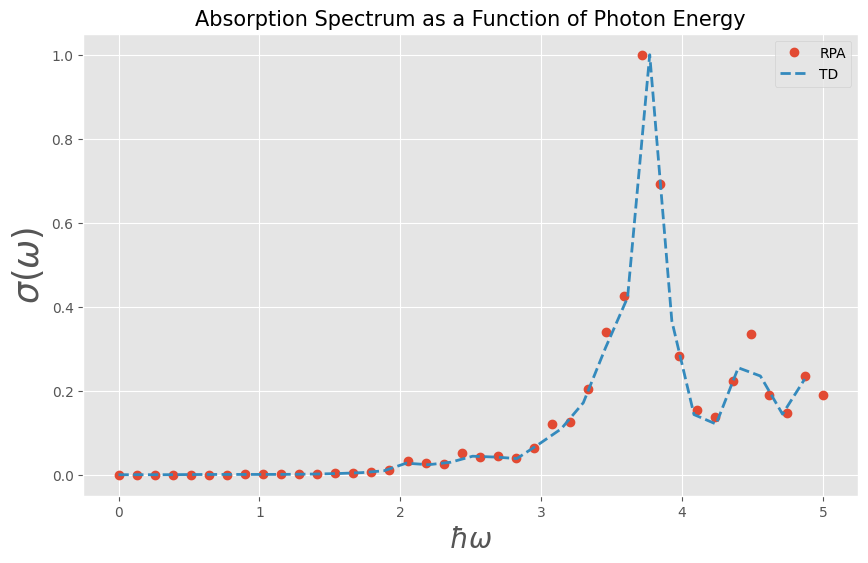

In [6]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
plt.plot(omegas_rpa, absorption_rpa / jnp.max(absorption_rpa), 'o', linewidth=2, label = 'RPA')
plt.plot(omegas, absorption_td / jnp.max(absorption_td), linewidth=2, ls = '--', label = 'TD' ) 
plt.xlabel(r'$\hbar\omega$', fontsize=20)
plt.ylabel(r'$\sigma(\omega)$', fontsize=25)
plt.title('Absorption Spectrum as a Function of Photon Energy', fontsize=15)
plt.legend()
plt.grid(True)
plt.show()